#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, roc_auc_score,precision_score,accuracy_score,roc_curve,make_scorer
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [33]:
train = pd.read_csv('data/train.csv')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* loan_amnt  - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* installment - The monthly payment owed by the borrower if the loan originates.
* home_ownership    
* emp_title                   
* annual_inc                  
* verification_status  - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
* purpose                 
* dti -  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* open_acc                  
* total_acc                    
* initial_list_status - The initial listing status of the loan. Possible values are – W, F           
* collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections
* application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
* acc_now_delinq - The number of accounts on which the borrower is now delinquent.


## Анализ и визуализация данных

In [35]:
aim = train['loan_status'] # целевой признак
others = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt'] ]# параметры

In [36]:
others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [37]:
Nan_killer(others, num = 0)

In [38]:
others.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

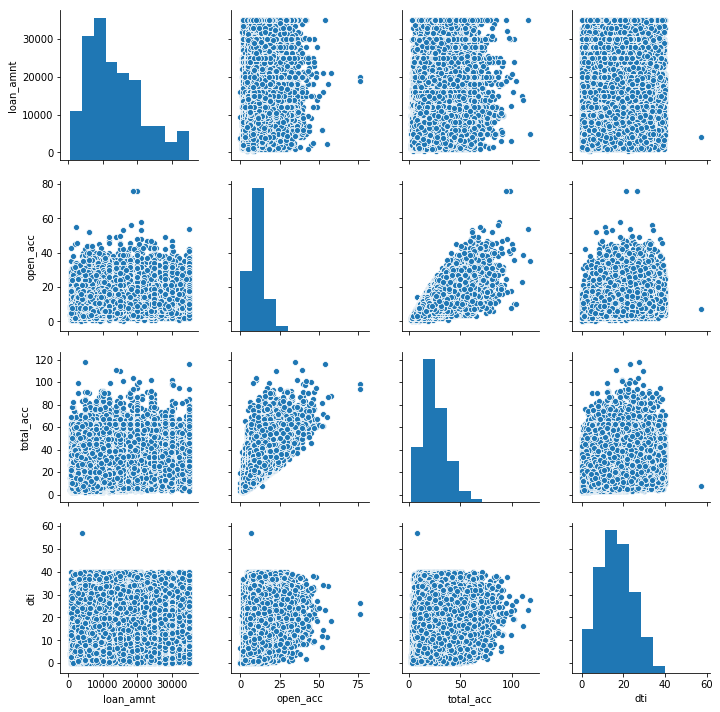

In [39]:
cols = ['loan_amnt',  'open_acc', 'total_acc', 'dti']
sns_plot = sns.pairplot(others[cols])

In [40]:
corr_matrix = others.drop(list(others.columns[others.dtypes == 'object']), axis=1).corr()

In [41]:
corr_matrix

,annual_inc,int_rate,installment,open_acc,total_acc,dti,tot_cur_bal,inq_last_6mths,total_rev_hi_lim,revol_bal,revol_util,tot_coll_amt,loan_amnt
annual_inc,1.000000,-0.027436,0.339094,0.143083,0.209921,-0.175599,0.377980,0.057436,0.268325,0.320178,0.023723,0.005441,0.344462
int_rate,-0.027436,1.000000,0.206644,0.041238,-0.011502,0.178122,-0.001475,0.212601,-0.047586,0.020464,0.331721,0.005966,0.216472
installment,0.339094,0.206644,1.000000,0.199681,0.216059,0.053766,0.292476,0.025670,0.323554,0.332390,0.129979,-0.015226,0.954744
open_acc,0.143083,0.041238,0.199681,1.000000,0.671889,0.306524,0.249709,0.115899,0.351871,0.234050,-0.108343,0.007064,0.204473
total_acc,0.209921,-0.011502,0.216059,0.671889,1.000000,0.229072,0.297077,0.140343,0.282630,0.210240,-0.088651,0.030096,0.234472
dti,-0.175599,0.178122,0.053766,0.306524,0.229072,1.000000,0.054610,-0.000846,0.125916,0.156204,0.219544,-0.020154,0.054016
tot_cur_bal,0.377980,-0.001475,0.292476,0.249709,0.297077,0.054610,1.000000,0.046861,0.507130,0.373497,0.074267,0.001149,0.312455
inq_last_6mths,0.057436,0.212601,0.025670,0.115899,0.140343,-0.000846,0.046861,1.000000,0.018674,-0.013295,-0.091625,0.012351,0.008532
total_rev_hi_lim,0.268325,-0.047586,0.323554,0.351871,0.282630,0.125916,0.507130,0.018674,1.000000,0.691546,-0.089591,-0.024860,0.339488
revol_bal,0.320178,0.020464,0.332390,0.234050,0.210240,0.156204,0.373497,-0.013295,0.691546,1.000000,0.239434,-0.027422,0.341718


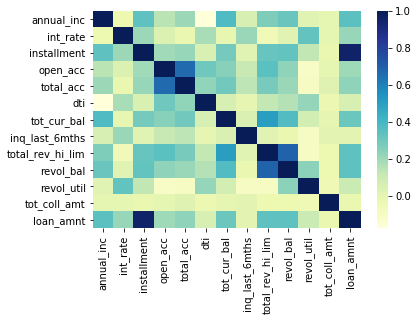

In [42]:
sns.heatmap(corr_matrix,cmap="YlGnBu");

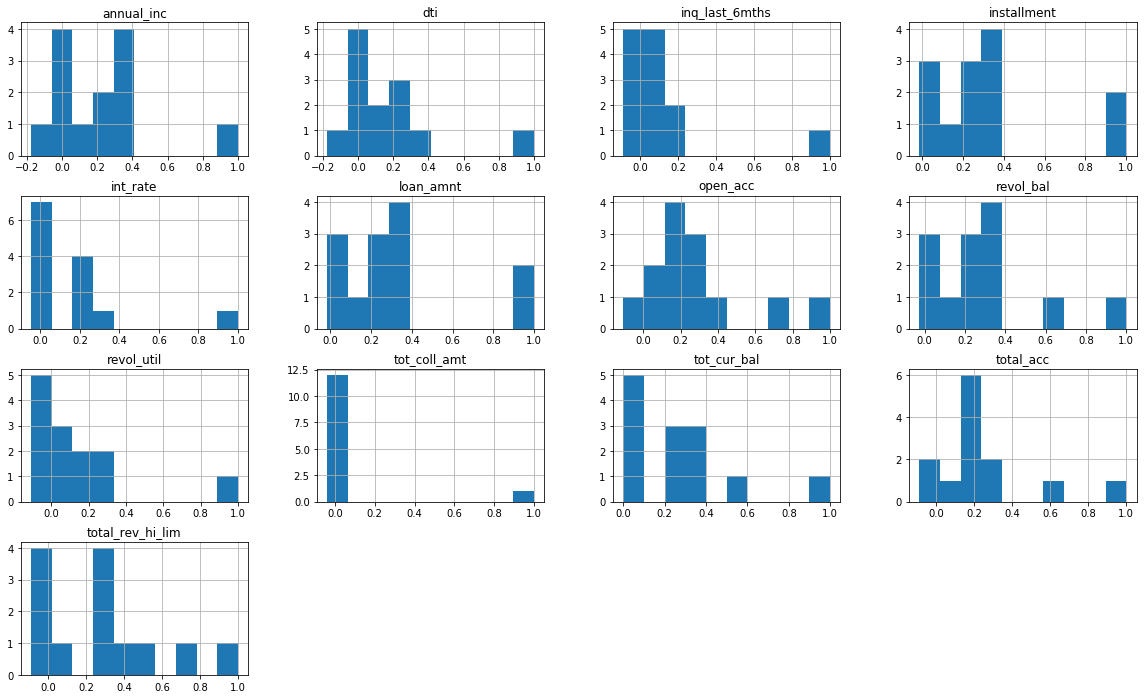

In [43]:
features = others.drop(list(others.columns[others.dtypes == 'object']), axis=1).corr()
features.hist(figsize=(20,12));

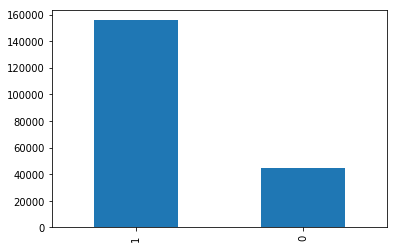

In [44]:
aim.value_counts().plot(kind='bar', label='loan_status')

In [49]:
others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

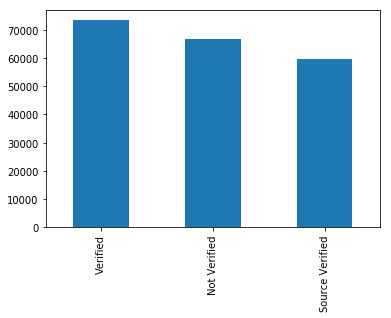

In [50]:
others['verification_status'].value_counts().plot(kind='bar', label='verification_status ')

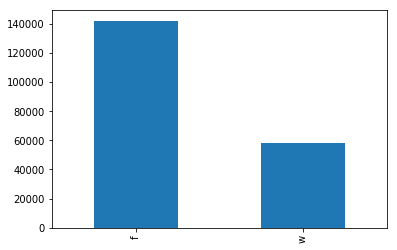

In [51]:
others['initial_list_status'].value_counts().plot(kind='bar', label='initial_list_status')

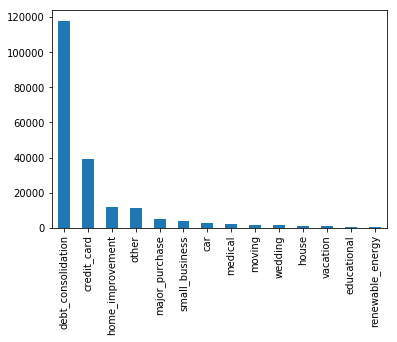

In [52]:
others['purpose'].value_counts().plot(kind='bar', label='purpose')

## Начальная обработка данных:

In [146]:
def Nan_killer(x, num = -999):
    x['revol_util'] = x['revol_util'].fillna(num)
  #  x['tot_coll_amt'] = x['tot_coll_amt'].fillna(num)
    x['tot_cur_bal'] =  x['tot_cur_bal'].fillna(num)
    x['total_rev_hi_lim'] =  x['total_rev_hi_lim'].fillna(num)
    

In [145]:
def proc(x,y):
  #  x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)
  #  x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
    x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
    x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
    x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership','term','verification_status'])   # OHE (?????)
    x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership','term','verification_status'])
    for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
        if i not in list(x_train):
            list(my_dataframe)
            x_test.drop(i, axis=1, inplace=True)
    for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
        if i not in list(x_test):
            x_test[i] = 0
    

    x_test = x_test.reindex(sorted(x_test.columns), axis=1)
    x_train = x_train.reindex(sorted(x_test.columns), axis=1)
    return x_train, x_test, y_train, y_test

## Функция для отображения метрик:
* ROC-AUC
* precision
* recall
* accuracy

In [120]:

def show_scores(model, x_test, y_test):
    pred =  model.predict(x_test)
    print('Recall: %.2f' % recall_score(y_test,pred))
    print('Precision score: %.2f' % precision_score(y_test,pred))
    print('Accuracy score: %.2f' % accuracy_score(y_test, pred))
 

In [121]:
def plot_roc(model, x_test, y_test):  
    pred = model.predict_proba(x_test)
    print("ROC-AUC score: ", roc_auc_score(y_test, pred[:, 1]))
    fpr, tpr,_=roc_curve(y_test,pred[:, 1],drop_intermediate=True)
    plt.figure()
    plt.plot(fpr, tpr, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

# Регрессия

In [38]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

In [191]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','loan_status',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

In [195]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 15 columns):
annual_inc             200189 non-null float64
initial_list_status    200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
grade                  200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
loan_status            200189 non-null int64
tot_coll_amt           200189 non-null float64
loan_amnt              200189 non-null float64
dtypes: float64(10), int64(1), object(4)
memory usage: 22.9+ MB


In [196]:
x.nunique()

annual_inc             16284
initial_list_status        2
installment            41347
open_acc                  58
total_acc                105
dti                     3975
purpose                   14
grade                      7
home_ownership             6
inq_last_6mths             9
revol_bal              44045
revol_util              1180
loan_status                2
tot_coll_amt            3646
loan_amnt               1317
dtype: int64

In [42]:
x_train, x_test, y_train, y_test = proc(x,y)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null int64
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-nul

In [44]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 8644 to 191094
Data columns (total 43 columns):
acc_now_delinq                60057 non-null float64
annual_inc                    60057 non-null float64
application_type              60057 non-null int64
collections_12_mths_ex_med    60057 non-null float64
dti                           60057 non-null float64
grade_A                       60057 non-null uint8
grade_B                       60057 non-null uint8
grade_C                       60057 non-null uint8
grade_D                       60057 non-null uint8
grade_E                       60057 non-null uint8
grade_F                       60057 non-null uint8
grade_G                       60057 non-null uint8
home_ownership_ANY            60057 non-null int64
home_ownership_MORTGAGE       60057 non-null uint8
home_ownership_NONE           60057 non-null uint8
home_ownership_OTHER          60057 non-null uint8
home_ownership_OWN            60057 non-null uint8
home_ownersh

## Линейная регрессия  + Дерево решений (регрессия)

In [15]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42).fit(x_train,y_train)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, min_samples_leaf = 3).fit(x_train,y_train)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(y_test, lm.predict(x_test))

0.9146765103292894

In [18]:
r2_score(y_test, dec_reg.predict(x_test))

0.9280174951473175

# Бинарная классификация

In [147]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','verification_status','int_rate','term',
                 'open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util','loan_amnt']] # параметры

In [148]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 16 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
term                   200189 non-null object
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
loan_amnt              200189 non-null float64
dtypes: float64(11), object(5)
memory usage: 24.4+ MB


In [149]:
x_train, x_test, y_train, y_test = proc(x,y)

In [150]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 37 columns):
annual_inc                             140132 non-null float64
dti                                    140132 non-null float64
home_ownership_ANY                     140132 non-null uint8
home_ownership_MORTGAGE                140132 non-null uint8
home_ownership_NONE                    140132 non-null uint8
home_ownership_OTHER                   140132 non-null uint8
home_ownership_OWN                     140132 non-null uint8
home_ownership_RENT                    140132 non-null uint8
inq_last_6mths                         140132 non-null float64
int_rate                               140132 non-null float64
loan_amnt                              140132 non-null float64
open_acc                               140132 non-null float64
purpose_car                            140132 non-null uint8
purpose_credit_card                    140132 non-null uint8
purpose_debt_conso

In [151]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 37 columns):
annual_inc                             140132 non-null float64
dti                                    140132 non-null float64
home_ownership_ANY                     140132 non-null uint8
home_ownership_MORTGAGE                140132 non-null uint8
home_ownership_NONE                    140132 non-null uint8
home_ownership_OTHER                   140132 non-null uint8
home_ownership_OWN                     140132 non-null uint8
home_ownership_RENT                    140132 non-null uint8
inq_last_6mths                         140132 non-null float64
int_rate                               140132 non-null float64
loan_amnt                              140132 non-null float64
open_acc                               140132 non-null float64
purpose_car                            140132 non-null uint8
purpose_credit_card                    140132 non-null uint8
purpose_debt_conso

## Логистическая регрессия

In [270]:
from sklearn import linear_model

In [271]:
lr = linear_model.LogisticRegression(solver='liblinear',random_state=42).fit(x_train, y_train)
lr.predict(x_test)
show_scores(lr, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.6926848879023262


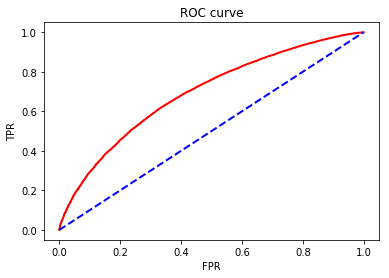

In [272]:
plot_roc(lr, x_test, y_test)

## Дерево решений (классификация)

In [273]:
from sklearn.tree import DecisionTreeClassifier

In [274]:
clf_tree = DecisionTreeClassifier(criterion='entropy',splitter = 'random', max_depth=12, random_state=42, min_samples_leaf = 3)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

In [275]:
show_scores(clf_tree, x_test, y_test)

Recall: 0.96
Precision score: 0.79
Accuracy score: 0.77


ROC-AUC score:  0.6754340131251977


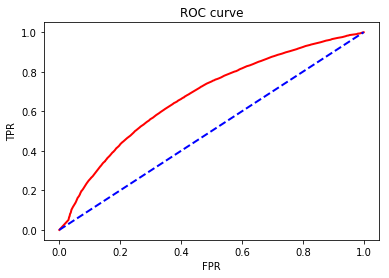

In [276]:
plot_roc(clf_tree, x_test, y_test)

## Случайный лес

In [277]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [278]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [12,10,8],
#    'min_samples_leaf': [1,3,5,7],
#    'n_estimators': [80,100,200,500],
#    'criterion' : ['entropy','gini'],
#}
#score = make_scorer(roc_auc_score)
#rf =  RandomForestClassifier(random_state = 42)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 5, n_jobs = -1, verbose = 2, scoring=score)
#grid_search.fit(x_train,  y_train)
#grid_search.best_params_
# best_grid = grid_search.best_estimator_

In [279]:
best_grid = RandomForestClassifier(random_state = 42, bootstrap = True, 
                                   max_depth = 12, min_samples_leaf = 1,
                                   n_estimators = 80, criterion = 'entropy')
best_grid.fit(x_train,  y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [280]:
best_grid.predict(x_test)
show_scores(best_grid, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7088091643978713


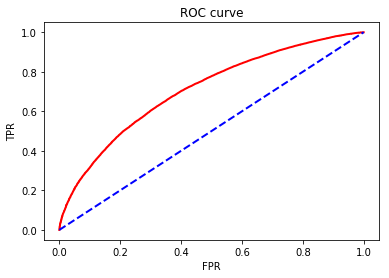

In [281]:
plot_roc(best_grid, x_test, y_test)

## VotingClassifier

In [282]:
from sklearn.ensemble import VotingClassifier

In [283]:
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', best_grid)],voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...mators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [284]:
show_scores(voting_clf, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7062283982087683


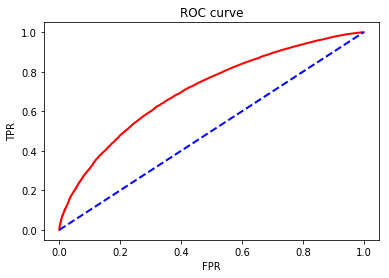

In [285]:
plot_roc(voting_clf, x_test, y_test)

## Xgboost (Grid search)

[Параметры XGBClassifier](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [152]:
import xgboost as xgb

In [153]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 37 columns):
annual_inc                             140132 non-null float64
dti                                    140132 non-null float64
home_ownership_ANY                     140132 non-null uint8
home_ownership_MORTGAGE                140132 non-null uint8
home_ownership_NONE                    140132 non-null uint8
home_ownership_OTHER                   140132 non-null uint8
home_ownership_OWN                     140132 non-null uint8
home_ownership_RENT                    140132 non-null uint8
inq_last_6mths                         140132 non-null float64
int_rate                               140132 non-null float64
loan_amnt                              140132 non-null float64
open_acc                               140132 non-null float64
purpose_car                            140132 non-null uint8
purpose_credit_card                    140132 non-null uint8
purpose_debt_conso

In [154]:
xgbst = xgb.XGBClassifier(
                           max_depth=3,
                           min_child_weight=3, #Defines the minimum sum of weights of all observations required
                           gamma = 0.25, 
                                    #A node is split only when the resulting split gives a positive 
                                    #reduction in the loss function. Gamma specifies the minimum loss 
                                    #reduction required to make a split.in a child
                           eval_metric = 'auc',                         
                           subsample= 0.52,
                                    #Denotes the fraction of observations to be randomly sampled for each tree
                           colsample_bytree=0.95, #The number of features to consider while searching for the best split
                           reg_alpha= 5,# L1 regularization term on weights
                           reg_lambda=0,# L2 regularization term on weights.
                           learning_rate = 0.01,
                           n_estimators =4000,
                           objective='binary:logistic',
                           
                           verbosity  = 2, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
                          
                           scale_pos_weight=1, #Control the balance of positive and negative weights, useful for unbalanced classes
                           seed=20,
                           random_state= 42,
                           missing=None)

In [155]:
xgbst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, eval_metric='auc', gamma=0.25,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=5, reg_lambda=0, scale_pos_weight=1, seed=20, silent=True,
       subsample=0.52, verbosity=2)

In [156]:
show_scores(xgbst, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7155965058720222


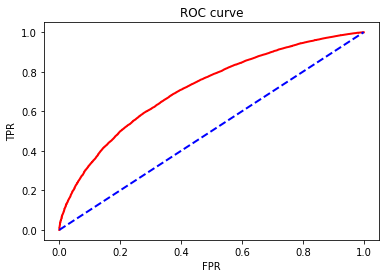

In [157]:
plot_roc(xgbst, x_test, y_test)

## Xgboost (Hypetopt)

In [158]:
from sklearn.metrics import r2_score
from hyperopt import tpe, hp, fmin
import xgboost as xgb
from hyperopt.mongoexp import MongoTrials

In [168]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 37 columns):
annual_inc                             140132 non-null float64
dti                                    140132 non-null float64
home_ownership_ANY                     140132 non-null uint8
home_ownership_MORTGAGE                140132 non-null uint8
home_ownership_NONE                    140132 non-null uint8
home_ownership_OTHER                   140132 non-null uint8
home_ownership_OWN                     140132 non-null uint8
home_ownership_RENT                    140132 non-null uint8
inq_last_6mths                         140132 non-null float64
int_rate                               140132 non-null float64
loan_amnt                              140132 non-null float64
open_acc                               140132 non-null float64
purpose_car                            140132 non-null uint8
purpose_credit_card                    140132 non-null uint8
purpose_debt_conso

In [169]:
def func(args):
    loss = 0
    if args['model'] == xgb.XGBClassifier:
        max_depth = args['param']['max_depth']
        min_child_weight = args['param']['min_child_weight']
        gamma = args['param']['gamma']
        subsample = args['param']['subsample']
        colsample_bytree = args['param']['colsample_bytree']
        reg_alpha = args['param']['reg_alpha']
        clf = xgb.XGBClassifier(eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.1,
                               n_estimators=1000,    
                               reg_lambda=0,
                               max_depth = max_depth,
                               min_child_weight =min_child_weight,
                               gamma =  gamma,
                               subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_alpha = reg_alpha)
        clf.fit(x_train,y_train)
        y_pred_test = clf.predict_proba(x_test)
        loss =  roc_auc_score(y_test, y_pred_test[:, 1])
        print("Test Score:",loss)
        print("Train Score:",roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1]))
        print("\n=================")
    return -loss


In [170]:
space = hp.choice('classifier',[
        {
        'model': xgb.XGBClassifier,
        'param': {
        'max_depth' : hp.choice('max_depth',range(3,10,2)),
        'min_child_weight' : hp.choice('min_child_weight', range(1,6,2)),
        'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
        'subsample' : hp.choice('subsample', [i/10.0 for i in range(6,10)]),
        'colsample_bytree'  : hp.choice('colsample_bytree', [i/10.0 for i in range(6,10)]),
        'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 100])  
        }}
        ])
space

In [171]:
# trials = MongoTrials('mongo://localhost:27017/foo_db/jobs',exp_key='exp1')

In [172]:
best = fmin(func,space,algo=tpe.suggest,max_evals=100)
#best = {'classifier': 0,
# 'colsample_bytree': 1,
# 'gamma': 1,
# 'max_depth': 3,
# 'min_child_weight': 0,
# 'reg_alpha': 3,
# 'subsample': 0}

Test Score:                                                                                                            
0.6965527492010486                                                                                                     
Train Score:                                                                                                           
0.9261165778452309                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.7145263525396996                                                                                                     
Train Score:                                                                                                           
0.7277934013733851                      

0.705402103356253                                                                                                      
Train Score:                                                                                                           
0.8394117570614813                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.695003222482925                                                                                                      
Train Score:                                                                                                           
0.9550550504103844                                                                                                     
                                        

Train Score:                                                                                                           
0.9990295849963822                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.6891881235774553                                                                                                     
Train Score:                                                                                                           
0.9969665222361029                                                                                                     
                                                                                                                       
Test Score:                             

0.8434923988369889                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.7149551611785353                                                                                                     
Train Score:                                                                                                           
0.7342685997096696                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.7150255786545057                      

                                                                                                                       
Test Score:                                                                                                            
0.6869469257836943                                                                                                     
Train Score:                                                                                                           
0.9926883434092395                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.7149590048111779                                                                                                     
Train Score:                            

Test Score:                                                                                                            
0.7152111126462736                                                                                                     
Train Score:                                                                                                           
0.7305973444038087                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.7152111126462736                                                                                                     
Train Score:                                                                                                           
0.7305973444038087                      

0.7056771860162585                                                                                                     
Train Score:                                                                                                           
0.8311461201600141                                                                                                     
                                                                                                                       
Test Score:                                                                                                            
0.7056641701699558                                                                                                     
Train Score:                                                                                                           
0.8347909318278262                                                                                                     
                                        

Train Score:                                                                                                           
0.753722968287021                                                                                                      
                                                                                                                       
Test Score:                                                                                                            
0.7151745300894559                                                                                                     
Train Score:                                                                                                           
0.7307968790421484                                                                                                     
                                                                                                                       
Test Score:                             

In [177]:
best

{'classifier': 0,
 'colsample_bytree': 3,
 'gamma': 0,
 'max_depth': 1,
 'min_child_weight': 1,
 'reg_alpha': 4,
 'subsample': 1}

In [180]:
bst = xgb.XGBClassifier(     eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.01,
                               n_estimators=4000,    
                               reg_lambda=0,
                               seed = 20,
                               max_depth = best['max_depth'],
                               min_child_weight = best['min_child_weight'],
                               gamma =  best['gamma'],
                               subsample = best['subsample'],
                               colsample_bytree = 1,
                               reg_alpha = best['reg_alpha'])

In [181]:
bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=4000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=4,
       reg_lambda=0, scale_pos_weight=1, seed=20, silent=True, subsample=1,
       verbosity=2)

In [182]:
show_scores(bst, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7076620353360183


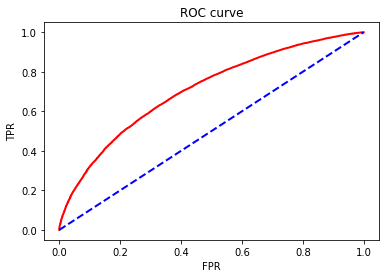

In [183]:
plot_roc(bst, x_test, y_test)

## Catboost

In [ ]:
from hyperopt import tpe, hp, fmin
import hyperopt 

In [ ]:
x['purpose'].value_counts()

In [ ]:
x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [ ]:
x['purpose'].value_counts()

In [ ]:
x['home_ownership'].value_counts()

In [ ]:
x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)

In [ ]:
x['home_ownership'].value_counts()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
# x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
# x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
# x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership'])   # OHE (?????)
# x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership'])
#for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
#    if i not in list(x_train):
#        list(my_dataframe)
#        x_test.drop(i, axis=1, inplace=True)
#for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
#    if i not in list(x_test):
#         x_test[i] = 0   

#x_test = x_test.reindex(sorted(x_test.columns), axis=1)
#x_train = x_train.reindex(sorted(x_test.columns), axis=1)

In [ ]:
x_train.info()

In [ ]:
x_train.head()

In [ ]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

In [ ]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

In [ ]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb
import frozendict
# roc_auc_score

In [ ]:
params = {'learning_rate': 0.01,
          'depth': 8.0,
       #   'rsm': 0.8789580279825991,
          'l2_leaf_reg': 29.083288170330242,
          'task_type': 'CPU',
          'loss_function': 'Logloss',
          'eval_metric': 'AUC', 'od_type': 'Iter',
          'od_wait': 40,
          'custom_metric': ['AUC'],
          'iterations': 4000,
          'random_seed': 42}
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)


In [ ]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

In [ ]:
show_scores(best_model, x_test, y_test)

In [ ]:
plot_roc(best_model, x_test, y_test)

In [ ]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

In [ ]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50

In [ ]:
const_params = frozendict.frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'od_type': 'Iter',
    'od_wait': 40,
    'custom_metric': ['AUC'],
    'iterations': 400,
    'random_seed':42})

In [ ]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'rsm' :  hyper_params['rsm'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}

    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()        
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=42,
            verbose=False)
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [ ]:

def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'depth': hp.quniform("depth", 4, 10, 1),
        'rsm': hp.uniform ('rsm', 0.75, 1.0),
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.01, 100)}
 
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=42))
    return best

def train_best_model(dataset, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization  
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params



In [ ]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

In [ ]:
params

In [ ]:
plot_roc(model, x_test, y_test)

In [ ]:
show_scores(model, x_test, y_test)

## LightGBM

In [33]:
import lightgbm as lgb

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
categorical_columns = x.columns[x.dtypes == 'object']
categorical_columns

Index(['initial_list_status', 'purpose', 'grade', 'home_ownership',
       'application_type'],
      dtype='object')

In [154]:
x_train['purpose'].value_counts()

debt_consolidation    82494
credit_card           27517
home_improvement       8322
other                  7876
major_purchase         3443
small_business         2665
car                    1964
medical                1589
moving                 1163
wedding                1028
house                   895
vacation                856
educational             182
renewable_energy        138
Name: purpose, dtype: int64

In [140]:
x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
categorical_columns = x.columns[x.dtypes == 'object']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null bool
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
purpose                       140132 non-null object
grade                         140132 non-null object
home_ownership                140132 non-null object
inq_last_6mths                140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt                 

In [127]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 20,
    'max_depth' : 6,
    'max_bin':100,
    'learning_rate':  0.35,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1' : 32,
    'verbose': 0}

In [128]:
params

{'boosting_type': 'dart',
 'objective': 'binary',
 'metric': {'auc'},
 'num_leaves': 20,
 'max_depth': 6,
 'max_bin': 100,
 'learning_rate': 0.35,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'lambda_l1': 32,
 'verbose': 0}

In [129]:
x_train.head()

,acc_now_delinq,annual_inc,application_type,collections_12_mths_ex_med,dti,grade_A,grade_B,grade_C,grade_D,grade_E,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,revol_bal,revol_util,tot_coll_amt,total_acc
193136,0.0,75000.0,True,0.0,26.85,0,1,0,0,0,...,0,0,0,0,0,0,38230.0,87.7,0.0,42.0
27784,0.0,73000.0,True,0.0,16.47,0,0,0,1,0,...,0,0,0,0,0,0,9874.0,41.0,0.0,38.0
157132,0.0,200000.0,True,0.0,13.50,1,0,0,0,0,...,0,0,0,0,0,0,34550.0,63.0,0.0,37.0
81962,0.0,100000.0,True,0.0,20.48,0,0,0,1,0,...,0,0,0,0,0,0,88599.0,60.9,0.0,36.0
161,0.0,65000.0,True,0.0,14.00,0,0,1,0,0,...,0,0,0,0,0,0,10948.0,43.6,0.0,19.0


In [130]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, free_raw_data=False)

In [131]:
evals_result = {}

In [132]:
num_train, num_feature = x_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

In [133]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=[lgb_train, lgb_eval],
               # feature_name=feature_name,              
              #  categorical_feature= categorical_features_indices,
             #   learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                evals_result=evals_result,
                verbose_eval=100)

[100]	training's auc: 0.720699	valid_1's auc: 0.708299
[200]	training's auc: 0.726036	valid_1's auc: 0.709584
[300]	training's auc: 0.730732	valid_1's auc: 0.710076
[400]	training's auc: 0.734714	valid_1's auc: 0.71066
[500]	training's auc: 0.738471	valid_1's auc: 0.710405
[600]	training's auc: 0.739775	valid_1's auc: 0.710752
[700]	training's auc: 0.742352	valid_1's auc: 0.711178
[800]	training's auc: 0.744439	valid_1's auc: 0.710858
[900]	training's auc: 0.746693	valid_1's auc: 0.710874
[1000]	training's auc: 0.748546	valid_1's auc: 0.710658
[1100]	training's auc: 0.750315	valid_1's auc: 0.709928
[1200]	training's auc: 0.751638	valid_1's auc: 0.709708
[1300]	training's auc: 0.75301	valid_1's auc: 0.709218
[1400]	training's auc: 0.755273	valid_1's auc: 0.708481
[1500]	training's auc: 0.756091	valid_1's auc: 0.708636
[1600]	training's auc: 0.757775	valid_1's auc: 0.708289
[1700]	training's auc: 0.759684	valid_1's auc: 0.708028
[1800]	training's auc: 0.761302	valid_1's auc: 0.707554
[19

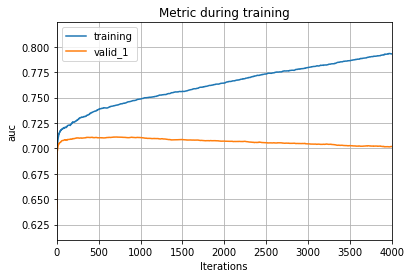

In [134]:
lgb.plot_metric(evals_result, metric='auc')
plt.show()